# Kinematic Bicycle Model #
## Dynamics ## 
(Note we are using the center of gravity as a reference)
$$ 
x = \begin{bmatrix}
      p_x \\ p_y \\ \theta \\ v
\end{bmatrix}, \quad
u = \begin{bmatrix}
    \alpha \\ \phi
\end{bmatrix}, \quad 
\dot{x} = 
\begin{bmatrix}
    v\cos\theta \\ v\sin\theta \\ 
     \phi \\ \alpha
\end{bmatrix} $$
where
$(p_x, p_y)$ is the position of the center of mass, $\theta$ is the yaw, $L$ is the distance between the front and rear wheels, and $\ell_r$ is the length form the center of mass to the rear wheel. 



In [ ]:
using ForwardDiff, LinearAlgebra
using Plots, Printf    # For showing results
using Interpolations   # May not actually be needed...

### General iLQR Stuff (from previous assignment)

In [28]:
"""
Calculate the continuous time dynamics ẋ = f(x,u), where 
  x is a vector of length nx, u is a vector of length nu.

returns ẋ
"""

function dynamics(x, u; L = 2, Lr = 1.5)
    # Kinematic Bicycle model (referenced to center of mass)
    
    θ, v = x[3:4]   # Yaw, steering angle, velocity
    α, ϕ = u        # Longitudinal acceleration, steering angle rate 
    
    s, c = sincos(θ)
    ẋ = v * c 
    ẏ = v * s 
    
    
    return [ẋ; ẏ; ϕ; α]
end

"""
Integrates the dynamics ODE 1 dt forward, x_{k+1} = rk4(x_k,u_k,dt).

returns x_{k+1}
"""
function rk4(x,u,dt)
    # rk4 for integration
    k1 = dt*dynamics(x, u)
    k2 = dt*dynamics(x + k1/2, u)
    k3 = dt*dynamics(x + k2/2, u)
    k4 = dt*dynamics(x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

"""
uses forward diff to get the following jacobians of the above discrete dynamics function (rk4):
drk4/dx = A 
drk4/du = B
"""
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = ForwardDiff.jacobian(_x -> rk4(_x, u, dt), x)
    B = ForwardDiff.jacobian(_u -> rk4(x, _u, dt), u)
    return A,B
end

function stage_cost(x, u, xref, uref)
    # LQR cost at each knot point (depends on both x and u) (equation provided above)
    J = 0.5 * (x - xref)' * Q * (x - xref) + 0.5 * (u - uref)' * R * (u - uref)
    
    return J
end

function term_cost(x, xref)
    # LQR terminal cost (depends on just x)
    J = 0.5 * (x - xref)' * Qf * (x - xref)
    
    return J
end

function trajectory_cost(X, U, Xref, Uref)
    
    N = size(Xref, 1)
    
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:(N-1)
        J += stage_cost(X[i], U[i], Xref[i], Uref[i])
    end
    
    return J + term_cost(X[N], Xref[N])
end
        
function stage_cost_expansion(x, u, xref, uref)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    
    Jₓ = Q * (x - xref) 
    Jᵤ = R * (u - uref) 
    
    Jₓₓ = Q 
    Jᵤᵤ = R 
    
    # Note that ∇ₓᵤJ = 0 = ∇ᵤₓJ
    
    return Jₓₓ, Jₓ, Jᵤᵤ, Jᵤ
end

function term_cost_expansion(x, xref )
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ

    Jₓ = Qf * (x - xref)
    Jₓₓ = Qf
    
    return Jₓₓ, Jₓ
end

"""
backward pass for iLQR. Inputs are 
    X - current trajectory              Vector{Vector}
    U - current control                 Vector{Vector}
    Xref - trajectory we want to track  Vector{Vector}
    Uref - control we want to track     Vector{Vector}

We will perform the backwards recursion without any regularization. Store the expected cost 
decrease in ΔJ and return the following 
    d - feedforward control             Vector{Vector}
    K - feedback gain matrices          Vector{Matrix}
    P - cost to go quadratic term       Vector{Matrix}
    ΔJ - expected cost decrease         Float
"""

function backward_pass(X, U, Xref, Uref, dt; ρ = 0.0)
    
    N = size(Xref, 1)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:N]     # cost to go quadratic term   ∇ₓₓV
    p = [zeros(nx) for i = 1:N]        # cost to go linear term      ∇ₓV
    d = [zeros(nu) for i = 1:N-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1]   # feedback gain
    ΔJ = 0.0                           # expected cost decrease
    
    # Initial term for P, p 
    P[end], p[end] = term_cost_expansion(X[end], Xref[end])
    
    for i = (N-1):(-1):1
        Jxx, Jx, Juu, Ju = stage_cost_expansion(X[i], U[i], Xref[i], Uref[i])
        A, B = dynamics_jacobians(X[i], U[i], dt)
        
        gx = Jx + A' * p[i + 1] 
        gu = Ju + B' * p[i + 1]
        Gxx = Jxx + A' * P[i + 1] * A 
        Guu = Juu + B' * P[i + 1] * B 
        Gxu = A' * P[i + 1]' * B            
        Gux = B' * P[i + 1] * A
        
#         Gxx = Gxx + I * ρ 
#         Guu = Guu + I * ρ
        
        d[i] =  Guu \ gu       # d = Gᵤᵤ⁻¹gᵤ 
        K[i] =  Guu \ Gux      # K = Gᵤᵤ⁻¹Gᵤₓ
        
        p[i] = gx  - K[i]' * gu +  K[i]' * Guu * d[i] - Gxu * d[i]
        P[i] = Gxx + K[i]' * Guu * K[i] - Gxu * K[i] - K[i]' * Gux

        ΔJ += gu' * d[i]
    end
    
    return d, K, P, ΔJ    
end

function forward_pass(X, U, Xref, Uref, K, d, ΔJ, dt; max_linesearch_iters = 20)
    
    J = trajectory_cost(X, U, Xref, Uref)  # Original cost of initial rollout
    
    α = 1.0
    
    Xn, Un, Jn = forward_pass_loop(X, U, Xref, Uref, K, d, α, dt)
    
    num_iters = 0
    while Jn >= (J - 0.01 * α * ΔJ)
        α = 0.5 * α
        Xn, Un, Jn = forward_pass_loop(X, U, Xref, Uref, K, d, α, dt)
        
        num_iters += 1
        if num_iters > max_linesearch_iters
#             @warn "Max Linesearch Iterations reached in forward pass!"
            break
        end
    end
    
    return Xn, Un, Jn, α
end


function forward_pass_loop(X, U, Xref, Uref, K, d, α, dt)
    N = size(X, 1)
    
    Xn, Un = deepcopy(X), deepcopy(U)
    
    for i = 1:(N - 1)
        Un[i] = U[i] - α * d[i] - K[i] * (Xn[i] - X[i])  
        Xn[i + 1] = rk4(Xn[i], Un[i], dt) 
    end
    Jn = trajectory_cost(Xn, Un, Xref, Uref)
    
    return Xn, Un, Jn 
end

"""
iLQR will combine the backward and forward passes for the complete iLQR algorithm. We will classify 
convergence as when the maximum norm of each feedforward control input in d is below atol. (this is given)

inputs:
    x0 - initial condition Vector
    U - initial control history Vector{Vector}
    Xref - reference trajectory we are trying to track Vector{Vector}
    Uref - reference controls we are trying to track Vector{Vector}

outputs:
    X - optimal trajectory Vector{Vector}
    U - optimal control trajectory Vector{Vector}
    K - feedback gain matrices Vector{Matrix}
    P - cost to go hessians Vector{Matrix}
    iter - iterations it took to converge Int
"""
function iLQR(x0, U, Xref, Uref, dt; atol = 1e-4, max_iters = 100, verbose = true)
    
    # initial logging stuff 

    if verbose
        @printf "iter     J\t\t           ΔJ\t\t        |d|\t         α\n"
        @printf "--------------------------------------------------------\n"
    end
    
    N = size(Xref, 1)
    
    P = [zeros(nx,nx) for i = 1:N]       # cost to go quadratic term   ∇ₓₓV
    d = [zeros(nu)    for i = 1:N - 1]   # feedforward control
    K = [zeros(nu,nx) for i = 1:N - 1]   # feedback gain
    X = [zeros(nx)    for i = 1:N]
    iter = -1 

    # Generate inital X using initial U 
    X[1] = copy(x0)
    for i = 1:N - 1  
        X[i + 1] = rk4(X[i], U[i], dt) 
    end

    if verbose
        J = trajectory_cost(X, U, Xref, Uref)
        println("(init)  \t$(round(J, digits = 5))")
    end

     
    for i = 1:max_iters
        dn, Kn, Pn, ΔJ = backward_pass(X, U, Xref, Uref, dt)
        d .= dn 
        K .= Kn 
        P .= Pn
    
        # Check for termination 
        dMax = maximum(norm.(d))  #maximum([maximum(abs.(d[j])) for j = 1:size(d, 1)])
        if dMax < atol
            println("$i  \t---     \t$(round(ΔJ, digits = 5))  \t$(round(dMax, digits = 5))  ")
            iter = i
            
#             break
            return X, U, Kn, Pn, iter

        end
        
        # Forward pass
        X, U, Jn, α = forward_pass(X, U, Xref, Uref, K, d, ΔJ, dt)
    
        
        if verbose
            println("$i  \t$(round(Jn, digits = 5))  \t$(round(ΔJ, digits = 5))  \t$(round(dMax, digits = 5))  \t$α")
        end
        
        
        if iter == max_iters
            @warn "Max iters hit in iLQR!"
        end
    end

    return X, U, K, P, iter

end
        

iLQR

## Generate Reference Trajectory 

In [20]:
# const x0 = [0.0; 0.0; 0.0; 0.0; 2.0]
const nx = 4   # Number of states 
const nu = 2   # Number of controls 


# THESE MAY NEED TO CHANGE DEPENDING ON TRAJECTORY
const Q = Diagonal([100.0 * ones(2); fill(0.01, 2)]) # Penalize (x, y) error 
const R = Diagonal(fill(1e-1, nu))          # 
const Qf = Diagonal([1000.0 * ones(2); fill(0.001, 2)])  # Don't care about terminal θ, δ, or v

# const dt = 1.0

4×4 Diagonal{Float64, Vector{Float64}}:
 1000.0      ⋅    ⋅      ⋅ 
     ⋅   1000.0   ⋅      ⋅ 
     ⋅       ⋅   0.001   ⋅ 
     ⋅       ⋅    ⋅     0.001

### Read in trajectory

In [21]:
function testTraj()
    """ Simplified trajectory for testing """
    pxs = [0, 1, 3, 4, 5, 5, 6, 7, 5, 5, 4, 5]
    pys = [0, 1, 2, 2, 4, 5, 5, 4, 5, 7, 6, 5]
    return pxs, pys
end

function createRef(file::String, dt, upSampleRate; verbose = false, L = 2, Lr = 1.5)
    """ 
          Generates a reference trajectory by first reading in a set of (x, y) positions, 
        and then estimating the yaw (θ), velocity (v), acceleration (α), and angular velocity 
        (ϕ) required to reach those states (ignores steering angle δ)
    """
    
    function wrap(A, B)
        """ Assumes in radians """
        return A - B
        A, B = rad2deg(A), rad2deg(B)
        Δ = (((A - B) + 180) % 360) - 180
        if Δ < -180 
            return deg2rad(Δ + 360)
        else 
            return deg2rad(Δ) 
        end
    
    end    
    
#     function wrap(θ)
#         while (θ > pi)
#             θ -= pi 
#         end
        
#         while (θ < -pi)
#             θ += pi 
#         end
        
#         return θ        
#     end
    
#     pxs, pys = testTraj()
    
    pxs, pys = getPositions(file); #pxs, pys = pxs[1:250], pys[1:250]
    N = length(pxs)
    
    method  = Cubic(Line(OnGrid()))  # Linear()
    ℓ = (N - 1) * upSampleRate + 1
    pxInt = interpolate(pxs, BSpline(method)) 
    pyInt = interpolate(pys, BSpline(method))

    pxs = pxInt(range(1, N, length = ℓ)) .- pxs[1]  # Center it, for plotting convenience
    pys = pyInt(range(1, N, length = ℓ)) .- pys[1]
    
    pxs = pxs / 10
    pys = pys / 10
    dtm = dt / upSampleRate 
    N = length(pxs)
    
    
    θs = [ atan(pys[i + 1] - pys[i], pxs[i + 1] - pxs[i]) for i = 1:N - 1]
    push!(θs, θs[end])
    
    vs = [ sqrt( (pys[i + 1] - pys[i])^2 + (pxs[i + 1] - pxs[i])^2) / (dtm)  for i = 1:N - 1 ]
    push!(vs, vs[end]) 
    
    ϕs = [ wrap(θs[i + 1], θs[i]) / dtm for i = 1:N - 1]
#     ϕs = [ϕs; ϕs[end]]
#     ϕs = [ wrap(θs[i], θs[i - 1]) / dtm for i = 2:N]
#     ϕs = [0.0; ϕs] #; ϕs[end]]

    αs = [ (vs[i + 1] - vs[i]) / dtm for i = 1:N - 1]
#     αs = [αs; αs[end]]
#     αs = [ (vs[i] - vs[i - 1]) / dtm for i = 2:N]
#     αs = [0.0; αs]


    Xref = [ [pxs[i], pys[i], θs[i], vs[i]] for i = 1:N]
    Uref = [ [αs[i], ϕs[i]] for i = 1:N-1]
    
    return Xref, Uref
end


function getPositions(file::String)
    """ Reads in a set of (x, y) positions from a .txt file"""
    pos = []
    open(file) do f

        # read till end of file

        while ! eof(f) 

            s = readline(f)  # Read in a row of data

            s = parse.(Float64, split(s, " "))  # Separate by spaces, and then convert to a float

            push!(pos, s)  # Add to the vector
        end
    end

    pos = hcat(pos...)'
    
    return pos[:, 1], pos[:, 2]
end


getPositions (generic function with 1 method)

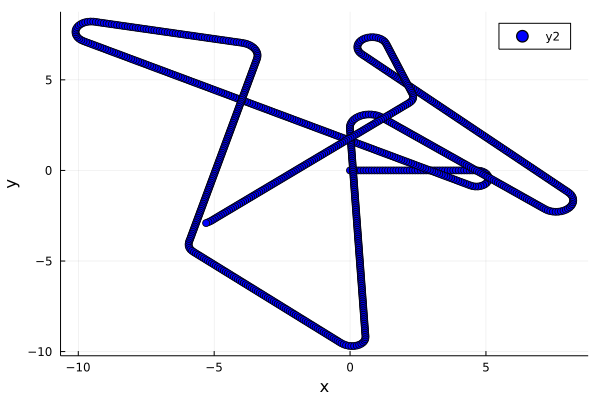

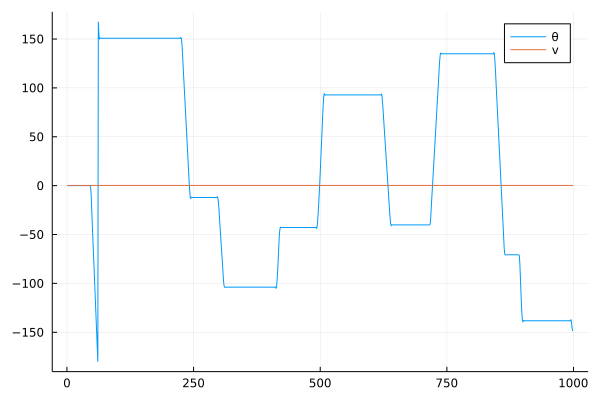

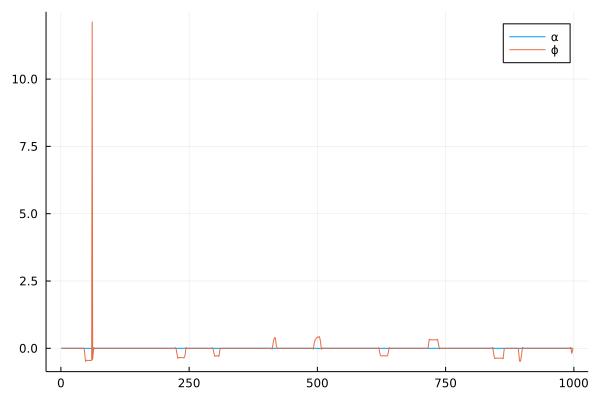

In [26]:
# GENERATES (AND PLOTS) THE REFERENCE TRAJECTORY 

file = "../logs/curvy_traj.txt" #"../logs/trajectory_good4.txt"
# file = "../datadir/trajectories/trajectory15.txt"
upSampleRate = 2
Xref, Uref = createRef(file, 1.0, upSampleRate);
# N = size(Xref, 1)

Xrefm = hcat(Xref...)'
plot(Xrefm[:, 1], Xrefm[:, 2], label = false)
display(scatter!(Xrefm[:, 1], Xrefm[:, 2], xlabel = "x", ylabel = "y", color = :blue))

plot(rad2deg.(Xrefm[:, 3]), label = "θ")
display(plot!(Xrefm[:, 4], label = "v"))

Urefm = hcat(Uref...)'
display(plot(Urefm, label = ["α" "ϕ"]))

iter     J		           ΔJ		        |d|	         α
--------------------------------------------------------
(init)  	439.64891
1  	1125.58693  	-4.051530794082588e277  	2.08962  	1.0
2  	1109.75479  	-5.175329122145238e273  	0.0045  	1.0
3  	1125.61193  	-2.1733802643251286e272  	0.00297  	1.0
4  	1125.61193  	7.492216823898592e273  	0.00518  	4.76837158203125e-7
5  	1110.8661  	-9.546479787411952e272  	0.0041  	1.0
6  	1121.22815  	-1.8111643071437792e273  	0.00168  	1.0
7  	1121.22815  	2.099641749718818e274  	0.01044  	4.76837158203125e-7
8  	1144.53565  	-1.8640748725153927e273  	0.00508  	1.0
9  	1144.53566  	6.713790643589463e272  	0.00124  	4.76837158203125e-7
10  	1183.63748  	-6.571496892161613e273  	0.01097  	1.0
11  	1187.42779  	-1.9129511280876922e270  	0.00049  	1.0
12  	1164.99508  	-2.5705562258010953e272  	0.00505  	1.0
13  	1153.14922  	-4.5060530959163224e272  	0.00276  	1.0
14  	1149.36609  	-7.821383402360832e272  	0.00072  	1.0
15  	1147.41947  	-1.1919374566099813

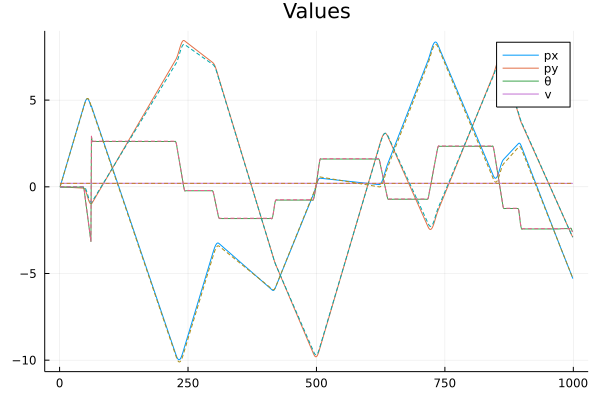

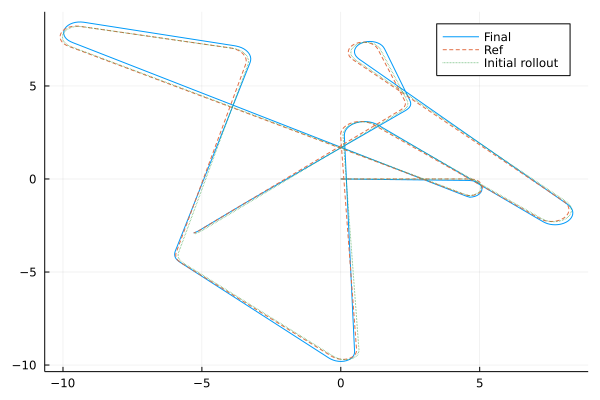

100  	1176.42996  	-3.680068418661175e272  	0.0013  	1.0


In [27]:
# RUN  iLQR
x0 = Xref[1]
X, U, K, _, _ = iLQR(x0, Uref, Xref, Uref, 1.0 / upSampleRate);


# Plot 
Xrefm = hcat(Xref...)'
a = plot(hcat(X...)', label = ["px" "py" "θ" "v"])
a = plot!(Xrefm, ls = :dash, label = false, title = "Values")
display(a)

Xinit = rollout(x0, Uref, 1.0 / upSampleRate)
Xinitm = hcat(Xinit...)'

Xm = hcat(X...)'

b = plot(Xm[:, 1], Xm[:, 2], label = "Final")
b = plot!(Xrefm[:, 1], Xrefm[:, 2], ls = :dash, label = "Ref")
b = plot!(Xinitm[:, 1], Xinitm[:, 2], ls = :dot, label = "Initial rollout")
display(b)


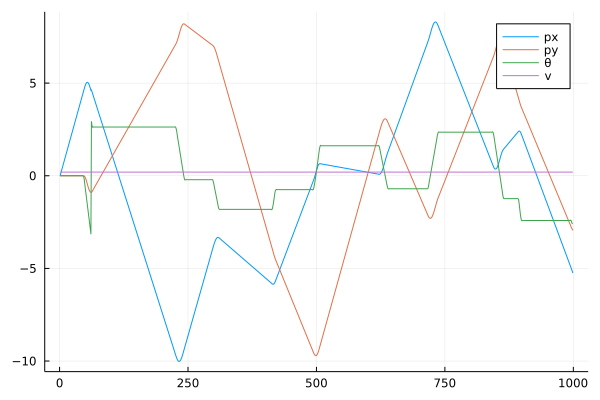

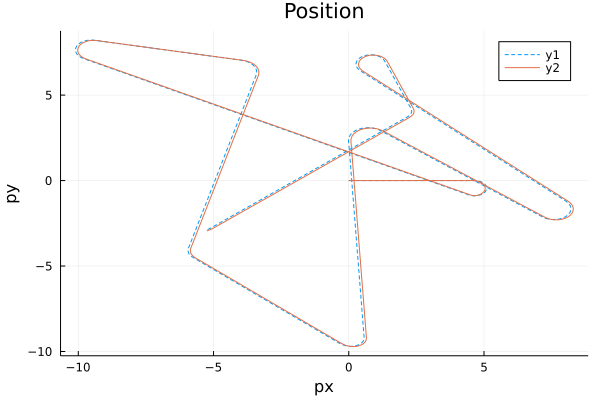

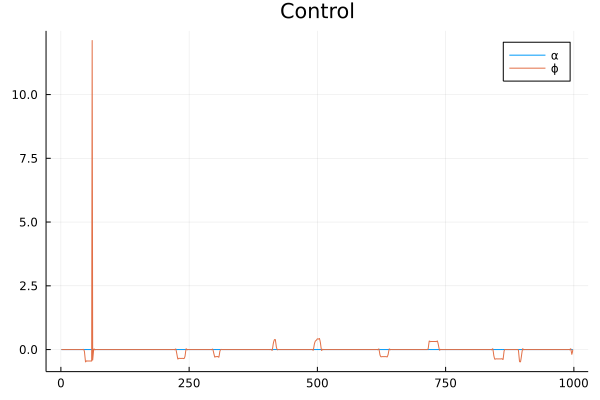

In [11]:
# HELPER FUNCTIONS TO ROLL OUT THE REFERENCE
# function wrap(X)
#     x, y, θ, v = X
#     # θ 
#     while (θ > pi)
#         θ -= pi
#     end
    
#     while (θ < -pi)
#         θ += pi
#     end
    
    
#     return [x, y, θ, v]
    
# end

function rollout(x0, Uref, dt)
    X = [x0 for i = 1:size(Uref, 1) + 1]
    X[1] = x0 
    
    for i = 1:size(X, 1) - 1
        Xn = rk4(X[i], Uref[i], dt) 
        X[i + 1] = Xn #wrap(Xn)
    end
    return X
end


# function disc_dyn(x, u, dt)
#     px, py, θ, v = x
#     α, ϕ = u 
    
#     px⁺ = px + v * dt * cos(θ)
#     py⁺ = py + v * dt * sin(θ)
#     θ⁺  = θ  + ϕ * dt 
#     v⁺  = v + α * dt 
    
#     return [px⁺, py⁺, θ⁺, v⁺]
# end


function track(x0, Xref, Uref, dt, Ks)
    X = [x0 for i = 1:size(Xref, 1)]
    X[1] = x0 
    
    for i = 1:size(X, 1) - 1 
        u = Uref[i] - Ks[i] * (X[i] - Xref[i]) #+ [randn(), randn()] * 0.03
        X[i + 1] = rk4(X[i], u, dt) 
    end
    
    return X
    
end

function posError(X, Xref)
    N = size(X, 1)
    Xm = hcat(X...)
    Xrefm = hcat(Xref...)
    
    error = 0.0
    errs = zeros(N)
    for i = 1:N
        errs[i] = norm(Xm[1:2, i] - Xrefm[1:2, i])
        error += errs[i]
    end
    return errs
end

Xr = rollout(Xref[1], Uref, 1.0 / upSampleRate)
Xrm = hcat(Xr...)'
Xrefm = hcat(Xref...)'

# Xtrack = track(Xref[1], Xref, Uref, 1.0 / upSampleRate, K)
# Xtm = hcat(Xtrack...)'

# plot(Xrefm[:, 1], Xrefm[:, 2], ls = :dash)
# display(plot!(Xtm[:, 1], Xtm[:, 2]))

display(plot(Xrm, label = ["px" "py" "θ" "v"]))

plot(Xrefm[:, 1], Xrefm[:, 2], ls = :dash)
display(plot!(Xrm[:, 1], Xrm[:, 2], title = "Position", xlabel = "px", ylabel = "py"))
display(plot(hcat(Uref...)', title = "Control", label = ["α" "ϕ"]))

## MESHCAT Stuff

In [ ]:
# ADD IN MESHCAT WITH COOL SHADOW FOR REAL VS REF
using RobotZoo
using StaticArrays
include("car.jl")

In [ ]:
model = RobotZoo.BicycleModel(; L = 0.2, lr = 0.15)
vis = initialize_visualizer(model)
render(vis)

In [ ]:
Xref_static = [SVector{nx, Float64}(Xref[i]) for i = 1:N]
X_static    = [SVector{nx, Float64}(X[i]) for i = 1:N]

visualize!(vis, model, N * dt / 20.0, X_static)

In [ ]:
# using Colors
# # using TrajOptPlots
# visualize!(vis, model, N * dt / 4, X_static, Xref_static, colors=[colorant"blue", RGBA(0,0,1,0.5)])

In [ ]:
X[1:2]

In [ ]:
Xref[1:2]

### Run Trajectories

In [ ]:
function saveTraj(X, file)
    N = size(X, 1)
    x = [X[i][1] for i = 1:N]
    y = [X[i][2] for i = 1:N]
    
    touch(file)
    
    open(file, "a") do io
        for i = 1:N
            loc = "$(x[i]) $(y[i])"
            println(io, loc)
        end
#         close(io)
    end
    
end

In [ ]:
source_fldr = "../datadir/trajectories/"
output_fldr = "../datadir/ctrlTraj/"

foreach(readdir(source_fldr)) do file 

    @show source_fldr * file
    
    upSampleRate = 1
    Xref, Uref = createRef(source_fldr * file, dt, upSampleRate);
    N = size(Xref, 1)
    X, U, K, _, _ = iLQR(Xref[1], Uref, Xref, Uref; verbose = false);
    
    
    if sum(sum([isnan.(X[i]) for i = 1:N])) > 0
        println("Error with $file !")
    else
        saveTraj(X, output_fldr * file) 
    end

end

println("Done")